In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
!pip install jiwer
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
from torch import nn
import librosa
from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor, TrainingArguments, Trainer
import torchaudio
import torch
import torch.nn.functional as F
from tensorflow.keras import layers, Model, optimizers
from tensorflow.keras.layers import LayerNormalization,Input
from torch.utils.data import Dataset, DataLoader
train = pd.read_csv('/kaggle/input/bengaliai-speech/train.csv')
train['path']  = ['/kaggle/input/bengaliai-speech/train_mp3s/'+str(i)+'.mp3' for i in train['id']]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 4.3 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: rapidfuzz
    Found existing installation: rapidfuzz 3.1.1
    Uninstalling rapidfuzz-3.1.1:
      Successfully uninstalled rapidfuzz-3.1.1


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

#### Set configs here

In [2]:
batch_size = 8

#### Visualize Signal

torch.Size([1, 150912])


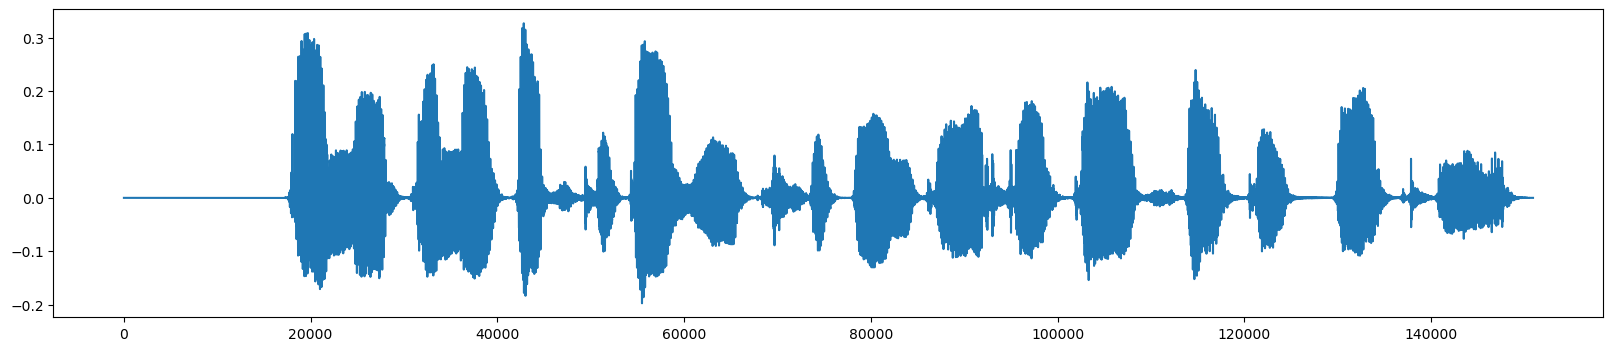

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:16                                                                                   │
│                                                                                                  │
│   13 plt.plot(waveform.t().numpy())                                                              │
│   14 plt.show()                                                                                  │
│   15 # Play the audio                                                                            │
│ ❱ 16 Audio(waveform, rate=sample_rate)                                                           │
│   17                                                                                             │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'Audio' is not defined

In [6]:
import torchaudio
import matplotlib.pyplot as plt

i = 2
# Load an MP3 file into a tensor
path = train['path'][i]
waveform, sample_rate = torchaudio.load(path)

# Print the shape of the waveform tensor
print(waveform.shape)

# Visualize the waveform
plt.figure(figsize=(20, 4))
plt.plot(waveform.t().numpy())
plt.show()
# Play the audio
Audio(waveform, rate=sample_rate)

for i in range(10000):
    path = train['path'][i] 
    waveform, sample_rate = torchaudio.load(path)
    file_name = '/kaggle/working/time_testing/'+str(train['id'][i])+'.pt'
    torch.save(waveform, file_name)

In [14]:
# Load an audio file as a waveform
waveform, sample_rate = librosa.load(path = train['path'][2])

# Extract MFCCs from the waveform
mfccs = librosa.feature.mfcc(y=waveform, sr=sample_rate)

mel_spectrogram = librosa.feature.melspectrogram(y=waveform, sr=sample_rate)

# Extract Spectral Contrast
spectral_contrast = librosa.feature.spectral_contrast(y=waveform, sr=sample_rate)

# Print the shape of the Spectral Contrast tensor
print(spectral_contrast.shape)

# Print the shape of the Mel-Scaled Spectrogram tensor
print(mel_spectrogram.shape)

# Print the shape of the MFCCs tensor
print(mfccs.shape)

(7, 204)
(128, 204)
(20, 204)


####  Testing Model - auditi41/wav2vec2-large-xlsr-53-Bengali

In [35]:
from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor
import torchaudio


# Specify the model name
model_name = "auditi41/wav2vec2-large-xlsr-53-Bengali"

# Load the pre-trained model
model = Wav2Vec2ForCTC.from_pretrained(model_name)

# Load the pre-trained model's processor
processor = Wav2Vec2Processor.from_pretrained(model_name)

waveform, sample_rate = librosa.load(path = train['path'][i],sr = 16000)

waveform_num = torch.from_numpy(waveform)

#resampler = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=16000)
#waveform_re = resampler(waveform_num)

inputs = processor(waveform_num, sampling_rate=sample_rate, return_tensors="pt", padding=True)

# Now you can input the preprocessed audio data to the model
outputs = model(**inputs)

# Get the model's predictions
logits = outputs.logits

# Get the predicted token ids
predicted_ids = torch.argmax(logits, dim=-1)

# Decode the token ids to get the transcription
transcription = processor.decode(predicted_ids[0])

actual = train['sentence'][i]

print(f'Model output: {transcription} and label is {actual}')

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Model output: ॥ইaড়‚বইঅড়ঁঅধদুুঅঊজঘঃঁখlদ‚ড়সুঅড়ঃঢaঁড় অদpড়lঅ।ড় and label is আমি তোমার কষ্টটা বুঝছি, কিন্তু এটা সঠিক পথ না।


### Creating Dataset

In [29]:
class BengaliData(Dataset):
    def __init__(self,train):
        # Initialize your data, download, etc.
        self.train = train
    
    def __len__(self):
        return len(self.train['path'])

    def __getitem__(self, index):
        obs_path = self.train['path'][index]
        waveform, sample_rate = librosa.load(path = obs_path,sr = 16000)
        waveform_num = torch.from_numpy(waveform)
        inputs = processor(waveform_num, sampling_rate=sample_rate, return_tensors="pt", padding=True)
        labels = self.train['sentence'][index]
        labels = processor(text=labels, padding=True, return_tensors="pt").input_ids
        ids = self.train['id'][index]
        return ids,inputs['input_values'], labels
Bengalidataset = BengaliData(train)

In [27]:
!mkdir /kaggle/working/preprocessed_auditi41_wav2vec2-large-xlsr-53-Bengali

### Preprocessed data into working directory

In [42]:

for i in range(1000):
    ids,inputs, labels = Bengalidataset[i]
    folder_to_save = '/kaggle/working/preprocessed_auditi41_wav2vec2-large-xlsr-53-Bengali'
    input_folder = folder_to_save + '/' + str(ids)
    !mkdir {input_folder}
    input_tensor_path = input_folder + '/' + 'input.pt'
    label_tensor_path = input_folder + '/' + 'label.pt'
    torch.save(inputs, input_tensor_path)
    torch.save(labels, label_tensor_path)

mkdir: cannot create directory ‘/kaggle/working/preprocessed_auditi41_wav2vec2-large-xlsr-53-Bengali/000005f3362c’: File exists
mkdir: cannot create directory ‘/kaggle/working/preprocessed_auditi41_wav2vec2-large-xlsr-53-Bengali/00001dddd002’: File exists
mkdir: cannot create directory ‘/kaggle/working/preprocessed_auditi41_wav2vec2-large-xlsr-53-Bengali/00001e0bc131’: File exists
mkdir: cannot create directory ‘/kaggle/working/preprocessed_auditi41_wav2vec2-large-xlsr-53-Bengali/000024b3d810’: File exists
mkdir: cannot create directory ‘/kaggle/working/preprocessed_auditi41_wav2vec2-large-xlsr-53-Bengali/000028220ab3’: File exists
mkdir: cannot create directory ‘/kaggle/working/preprocessed_auditi41_wav2vec2-large-xlsr-53-Bengali/00002b0c8953’: File exists
mkdir: cannot create directory ‘/kaggle/working/preprocessed_auditi41_wav2vec2-large-xlsr-53-Bengali/00003147472f’: File exists
mkdir: cannot create directory ‘/kaggle/working/preprocessed_auditi41_wav2vec2-large-xlsr-53-Bengali/000

In [30]:
#!mkdir /kaggle/working/preprocessed_eval_auditi41_wav2vec2-large-xlsr-53-Bengali
for i in range(1000,1100):
    ids,inputs, labels = Bengalidataset[i]
    folder_to_save = '/kaggle/working/preprocessed_eval_auditi41_wav2vec2-large-xlsr-53-Bengali'
    input_folder = folder_to_save + '/' + str(ids)
    !mkdir {input_folder}
    input_tensor_path = input_folder + '/' + 'input.pt'
    label_tensor_path = input_folder + '/' + 'label.pt'
    torch.save(inputs, input_tensor_path)
    torch.save(labels, label_tensor_path)

mkdir: cannot create directory ‘/kaggle/working/preprocessed_eval_auditi41_wav2vec2-large-xlsr-53-Bengali’: File exists


### Testing base model

### Save and load preprocessor and Model

In [3]:
!mkdir /kaggle/working/models/orginal_model_wav2vec2-large-xlsr-53-Bengali

# Specify the model name
model_name = "auditi41/wav2vec2-large-xlsr-53-Bengali"

model_path = '/kaggle/working/models/orginal_model_wav2vec2-large-xlsr-53-Bengali'

preprocessor_path = '/kaggle/working/models/preprocessor_wav2vec2-large-xlsr-53-Bengali'



# Load the pre-trained model
#model = Wav2Vec2ForCTC.from_pretrained(model_name)

# Save the original pre-trained model
#model.save_pretrained('/kaggle/working/models/orginal_model_wav2vec2-large-xlsr-53-Bengali')

# Load the pre-trained model's processor
#processor = Wav2Vec2Processor.from_pretrained(model_name)

# Save the original pre-trained processor
#processor.save_pretrained('/kaggle/working/models/preprocessor_wav2vec2-large-xlsr-53-Bengali')

mkdir: cannot create directory ‘/kaggle/working/models/orginal_model_wav2vec2-large-xlsr-53-Bengali’: File exists


### Loading Model and Preprocessor

In [4]:
# Load the original pre-trained processor
processor = Wav2Vec2Processor.from_pretrained(preprocessor_path)
# Load the original pre-trained model
model = Wav2Vec2ForCTC.from_pretrained(model_path)

### Dataset creation from preprocessed data

In [5]:
class BengaliDataTrain(Dataset):
    def __init__(self,train,path):
        # Initialize your data, download, etc.
        self.train = train
        self.path = path
    def __len__(self):
        return 1000 #len(self.train['path'])

    def __getitem__(self, index):
        obs_path = self.path + train['id'][index]+'/input.pt'
        label_path = self.path + train['id'][index]+'/label.pt'
        inputs = torch.load(obs_path)
        labels = torch.load(label_path)
        return {'input_values': inputs, 'labels':  labels}

In [6]:
from torch.nn.utils.rnn import pad_sequence


def collate_fn(batch):
    # Get the input_values and labels from the batch
    input_values = [item['input_values'] for item in batch]
    labels = [item['labels'] for item in batch]

    # Find the maximum length of the input_values and labels
    max_length_input = max(x.size(1) for x in input_values)
    max_length_labels = max(x.size(1) for x in labels)

    # Pad the input_values and labels to the maximum length
    input_values = [torch.cat([x, torch.zeros(1, max_length_input - x.size(1))], dim=1) for x in input_values]
    labels = [torch.cat([x, torch.zeros(1, max_length_labels - x.size(1))], dim=1) for x in labels]

    # Stack the input_values and labels into tensors
    input_values = torch.stack(input_values).squeeze(1)
    labels = torch.stack(labels).squeeze(1)

    return {'input_values': input_values, 'labels': labels}


train_dataset = BengaliDataTrain(train,'/kaggle/working/preprocessed_auditi41_wav2vec2-large-xlsr-53-Bengali/')
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,collate_fn=collate_fn)
eval_dataset = BengaliDataTrain(train,'/kaggle/working/preprocessed_eval_auditi41_wav2vec2-large-xlsr-53-Bengali/')
eval_loader = DataLoader(eval_dataset, batch_size=batch_size, shuffle=True,collate_fn=collate_fn)

In [7]:
import os

# Set the API key as an environment variable
os.environ["WANDB_API_KEY"] = '3616d79422ac647c25362d62aa7d6b046b8647ea'

### Finetune the pretrained model

In [15]:
from transformers import TrainingArguments, Trainer
from jiwer import wer
from tqdm import tqdm

torch.cuda.empty_cache()

from torch.utils.data import DataLoader
from transformers import Trainer

class MyTrainer(Trainer):
    def get_train_dataloader(self):
        train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
        for batch in train_dataloader:
            yield batch
            if self.args.device.type == "cuda":
                torch.cuda.empty_cache()

    def get_eval_dataloader(self, dataset=None):
        eval_dataloader = DataLoader(eval_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
        for batch in eval_dataloader:
            yield batch
            if self.args.device.type == "cuda":
                torch.cuda.empty_cache()



def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    # Decode the predictions and labels
    pred_str = processor.batch_decode(preds, skip_special_tokens=True)
    labels_str = processor.batch_decode(labels, skip_special_tokens=True)

    # Compute WER
    wer_score = wer(labels_str, pred_str)

    return {"wer": wer_score}

training_args = TrainingArguments(
    output_dir="/kaggle/working/models/model_checkpoints",
    num_train_epochs=3,
    per_device_train_batch_size=batch_size,  # reduce this if necessary
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir="/kaggle/working/models/logs",
    logging_steps=10,
    evaluation_strategy="epoch",
    gradient_accumulation_steps=4,  # add this line to use gradient accumulation
    fp16=True,
    #device = 'cuda'# add this line to use mixed precision training
)

trainer = MyTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics,

)

# Train the model

trainer.train()

# Save the model
model.save_pretrained('/kaggle/working/models/model_checkpoints')

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:66                                                                                   │
│                                                                                                  │
│   63                                                                                             │
│   64 # Train the model                                                                           │
│   65                                                                                             │
│ ❱ 66 trainer.train()                                                                             │
│   67                                                                                             │
│   68 # Save the model                                                                            │
│   69 model.save_pretrained('/kaggle/working/models/model_checkpoints')                           │
│                                                                                                  │
│ /opt/conda/lib/python3.10/site-packages/transformers/trainer.py:1645 in train                    │
│                                                                                                  │
│   1642 │   │   inner_training_loop = find_executable_batch_size(                                 │
│   1643 │   │   │   self._inner_training_loop, self._train_batch_size, args.auto_find_batch_size  │
│   1644 │   │   )                                                                                 │
│ ❱ 1645 │   │   return inner_training_loop(                                                       │
│   1646 │   │   │   args=args,                                                                    │
│   1647 │   │   │   resume_from_checkpoint=resume_from_checkpoint,                                │
│   1648 │   │   │   trial=trial,                                                                  │
│                                                                                                  │
│ /opt/conda/lib/python3.10/site-packages/transformers/trainer.py:1693 in _inner_training_loop     │
│                                                                                                  │
│   1690 │   │   │   num_examples = total_train_batch_size * args.max_steps                        │
│   1691 │   │   │   num_train_samples = args.max_steps * total_train_batch_size                   │
│   1692 │   │   else:                                                                             │
│ ❱ 1693 │   │   │   raise ValueError(                                                             │
│   1694 │   │   │   │   "args.max_steps must be set to a positive value if dataloader does not h  │
│   1695 │   │   │   │   f" {args.max_steps}"                                                      │
│   1696 │   │   │   )                                                                             │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
ValueError: args.max_steps must be set to a positive value if dataloader does not have a length, was -1

In [63]:
from torch.nn.utils.rnn import pad_sequence

def collate_fn(batch):
    # Get the input_values and labels from the batch
    input_values = [item['input_values'] for item in batch]
    labels = [item['labels'] for item in batch]

    # Find the maximum length of the input_values and labels
    max_length_input = max(x.size(1) for x in input_values)
    max_length_labels = max(x.size(1) for x in labels)

    # Pad the input_values and labels to the maximum length
    input_values = [torch.cat([x, torch.zeros(1, max_length_input - x.size(1))], dim=1) for x in input_values]
    labels = [torch.cat([x, torch.zeros(1, max_length_labels - x.size(1))], dim=1) for x in labels]

    # Stack the input_values and labels into tensors
    input_values = torch.stack(input_values).squeeze(1)
    labels = torch.stack(labels).squeeze(1)

    return {'input_values': input_values, 'labels': labels}




# Create a DataLoader
dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

# Get a batch from the DataLoader
batch = next(iter(dataloader))

# Print the shapes of the input_values and labels in the batch
print(batch['input_values'].shape)
print(batch['labels'].shape)

torch.Size([16, 141696])
torch.Size([16, 84])
